<a href="https://colab.research.google.com/github/meraat-am/Deep-Learning/blob/master/implicit_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation System

## 0. install and import

In [1]:
!pip install surprise

     |████████████████████████████████| 11.8MB 26.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617575 sha256=37fab40275c0d79dfc7f7bc26be04a961e410e16e8a52e1f2be13d9b65bd3aae
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
!pip install implicit

     |████████████████████████████████| 1.1MB 18.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406368 sha256=f75583d9f97fd66078d881fa2bdde0825f380bd573b9b337fbb194275fda2d95
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [3]:
!wget https://www.digikala.com/static/files/b683b250.xlsx

--2021-03-18 15:06:15--  https://www.digikala.com/static/files/b683b250.xlsx
Resolving www.digikala.com (www.digikala.com)... 91.99.72.75, 79.175.144.150, 92.114.19.26, ...
Connecting to www.digikala.com (www.digikala.com)|91.99.72.75|:443... failed: Connection timed out.
Connecting to www.digikala.com (www.digikala.com)|79.175.144.150|:443... failed: Connection timed out.
Connecting to www.digikala.com (www.digikala.com)|92.114.19.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘b683b250.xlsx’

b683b250.xlsx           [      <=>           ]  11.91M  6.43MB/s    in 1.9s    

2021-03-18 15:07:23 (6.43 MB/s) - ‘b683b250.xlsx’ saved [12484441]



In [120]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import hashlib
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc
from collections import defaultdict

import xgboost as xgb
from surprise import Reader, Dataset, SVDpp
from surprise.model_selection import KFold
from implicit.recommender_base import RecommenderBase
from implicit.als import AlternatingLeastSquares as ALS
from implicit.bpr import BayesianPersonalizedRanking as BPR
from implicit.lmf import LogisticMatrixFactorization as LMF
from implicit.evaluation import precision_at_k,AUC_at_k,ndcg_at_k,mean_average_precision_at_k,train_test_split

from surprise.model_selection import GridSearchCV

## 1. Reading and Storing Data

### Data Pre-processing

In [5]:
# creating data frame from our output csv file.
if not os.path.isfile("/content/DigikalaData.pkl"):
    startTime = datetime.now()
    Final_Data = pd.read_excel("/content/b683b250.xlsx",skiprows=1, names = ["OrderID","CustID","VarientID","MovieID","Ratings","Price","Date","CityID","CityName","StateID","StateName"])
    print("Time taken for execution of above code = "+str(datetime.now() - startTime))

Time taken for execution of above code = 0:00:16.850241


In [6]:
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile("/content/DigikalaData.pkl"):
    Final_Data.to_pickle("/content/DigikalaData.pkl")
else:
    Final_Data = pd.read_pickle("/content/DigikalaData.pkl")

In [7]:
Final_Data.head()

,OrderID,CustID,VarientID,MovieID,Ratings,Price,Date,CityID,CityName,StateID,StateName
0,262108413,SlcW7YT835JSzh22o7zRCA==,685868,435013,1,890000,2018-08-20 23:59:02,1698,تهران,9,تهران
1,262108353,NZidrSuPdqoG7RedrFakeA==,275077,163947,1,9890000,2018-08-20 23:58:39,1698,تهران,9,تهران
2,262108341,dLQImlfXMsgSub4OcfJpGg==,679393,158560,1,349000,2018-08-20 23:58:35,1855,مشهد,12,خراسان رضوی
3,262108293,O/xo6mGsu7adcgxofe+MdQ==,769096,479854,1,320000,2018-08-20 23:58:28,1698,تهران,9,تهران
4,262108245,qdl8iWQQhf5xNw4DrqvNtA==,840922,63831,1,479500,2018-08-20 23:58:17,1698,تهران,9,تهران


In [8]:
type(Final_Data['MovieID'][100])

numpy.int64

In [9]:
unique_users = len(np.unique(Final_Data["CustID"]))
unique_users

56104

In [10]:
unique_items = len(np.unique(Final_Data["MovieID"]))
unique_items

61734

In [11]:
hashAlgo = hashlib.md5()
def hasher_cust(x):
  hashAlgo.update(x.encode('utf-8'))
  return int(hashAlgo.hexdigest(),16) % (unique_users)

In [12]:
Final_Data['CustID'] = Final_Data['CustID'].apply(hasher_cust)

In [13]:
import uuid

In [14]:
def hasher_item(x):
  return (uuid.uuid1().int>>64)%(unique_items)

In [15]:
Final_Data['MovieID'] = Final_Data['MovieID'].apply(hasher_item)

In [16]:
Final_Data['MovieID'][9]

20937

In [17]:
# def corrector(x):
#   if(x>=0.5):
#     return 1
#   else:
#     return 0

In [18]:
# Final_Data['Ratings'] = Final_Data['Ratings'].apply(corrector)

In [19]:
Final_Data = Final_Data[['CustID','MovieID','Ratings']]

In [20]:
Final_Data.tail()

,CustID,MovieID,Ratings
199994,24252,39437,1
199995,51917,54469,1
199996,51496,40513,1
199997,6750,55545,1
199998,3799,8843,1


In [21]:
# Final_Data1=Final_Data
# Final_Data=Final_Data.loc[0:20000]

In [22]:
Final_Data.describe()["Ratings"]

count    199999.000000
mean          1.327397
std           1.428638
min          -2.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         100.000000
Name: Ratings, dtype: float64

In [23]:
print(max(Final_Data['CustID']),min(Final_Data['CustID']))
print(max(Final_Data['MovieID']),min(Final_Data['MovieID']))

56103 0
61733 1


### Checking for NaN

In [24]:
print("Number of NaN values = "+str(Final_Data.isnull().sum()))

Number of NaN values = CustID     0
MovieID    0
Ratings    0
dtype: int64


### Removing Duplicates

In [25]:
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 9


### Basic Statistics

In [26]:
print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))

Total Data:
Total number of movie ratings = 199999
Number of unique users = 54483
Number of unique movies = 30839


### Spliting data into Train and Test(80:20)

In [27]:
if not os.path.isfile("/content/TrainData.pkl"):
    pkler = Final_Data.iloc[:int(Final_Data.shape[0]*0.80)]
    # pkler = pkler.append(Final_notbought.iloc[:int(Final_notbought.shape[0]*0.80)])
    pkler.to_pickle("/content/TrainData.pkl")
    Train_Data = pd.read_pickle("/content/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("/content/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile("/content/TestData.pkl"):
    pkler = Final_Data.iloc[int(Final_Data.shape[0]*0.80):]
    # pkler = pkler.append(Final_notbought.iloc[int(Final_notbought.shape[0]*0.80):])
    pkler.to_pickle("/content/TestData.pkl")
    Test_Data = pd.read_pickle("/content/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("/content/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

### Basic Statistics in Train data

In [28]:
Train_Data.head()

,CustID,MovieID,Ratings
0,16897,48833,1
1,7017,12875,1
2,49010,35423,1
3,38181,21467,1
4,19991,7511,1


In [29]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))

Total Train Data:
Total number of movie ratings in train data = 159999
Number of unique users in train data = 52866
Number of unique movies in train data = 30744
Highest value of a User ID = 56103
Highest value of a Movie ID = 61733


### Basic Statistics in Test data

In [30]:
Test_Data.head()

,CustID,MovieID,Ratings
0,36803,33791,1
1,23432,23593,1
2,44881,13395,1
3,10477,3197,1
4,38877,54733,1


In [31]:
Test_Data.tail()

,CustID,MovieID,Ratings
39995,24252,39437,1
39996,51917,54469,1
39997,51496,40513,1
39998,6750,55545,1
39999,3799,8843,1


In [32]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 40000
Number of unique users in Test data = 28649
Number of unique movies in Test data = 22902
Highest value of a User ID = 56101
Highest value of a Movie ID = 61733


## 2. Exploratory Data Analysis on Train Data

In [33]:
def changingLabels(number):
    return str(number/10**6) + "M"

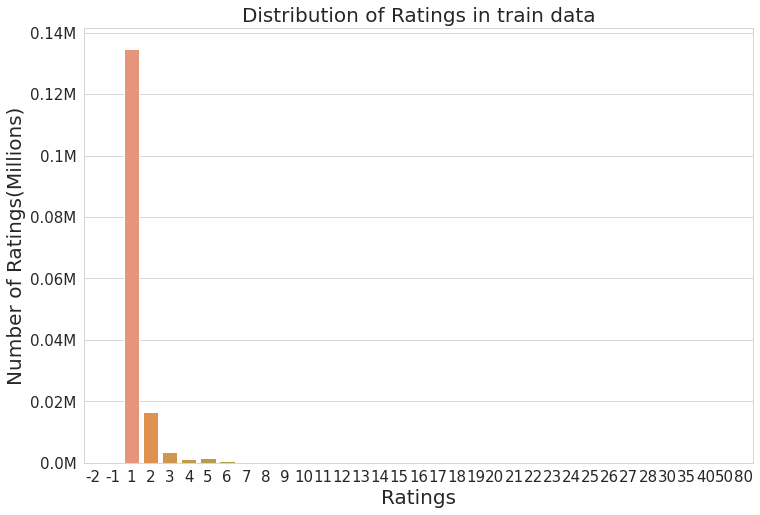

In [34]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Ratings", data=Train_Data)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

In [35]:
Train_Data.tail()

,CustID,MovieID,Ratings
159994,37497,19289,1
159995,19401,12849,1
159996,46184,2651,1
159997,25380,54187,1
159998,1153,43989,1


### Analysis of Ratings given by user

In [36]:
no_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

In [37]:
no_of_rated_movies_per_user.head()

CustID
19646    12
26058    12
55683    11
37440    11
44930    11
Name: Ratings, dtype: int64

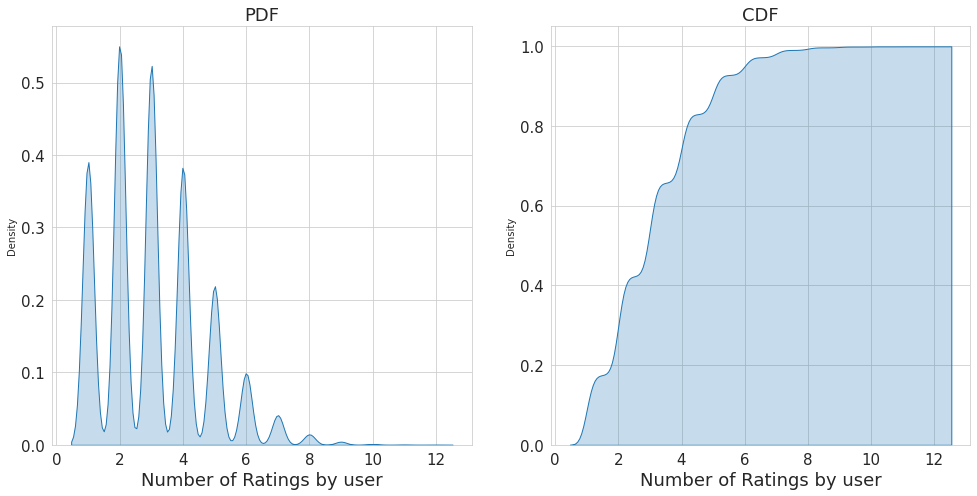

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

* Above PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.
* Similarly, above CDF graph shows that almost 99% of users give very few ratings.

In [39]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    52866.000000
mean         3.026501
std          1.572955
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: Ratings, dtype: float64

In [40]:
# no_of_rated_movies_per_user.describe()["75%"]

In [41]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))

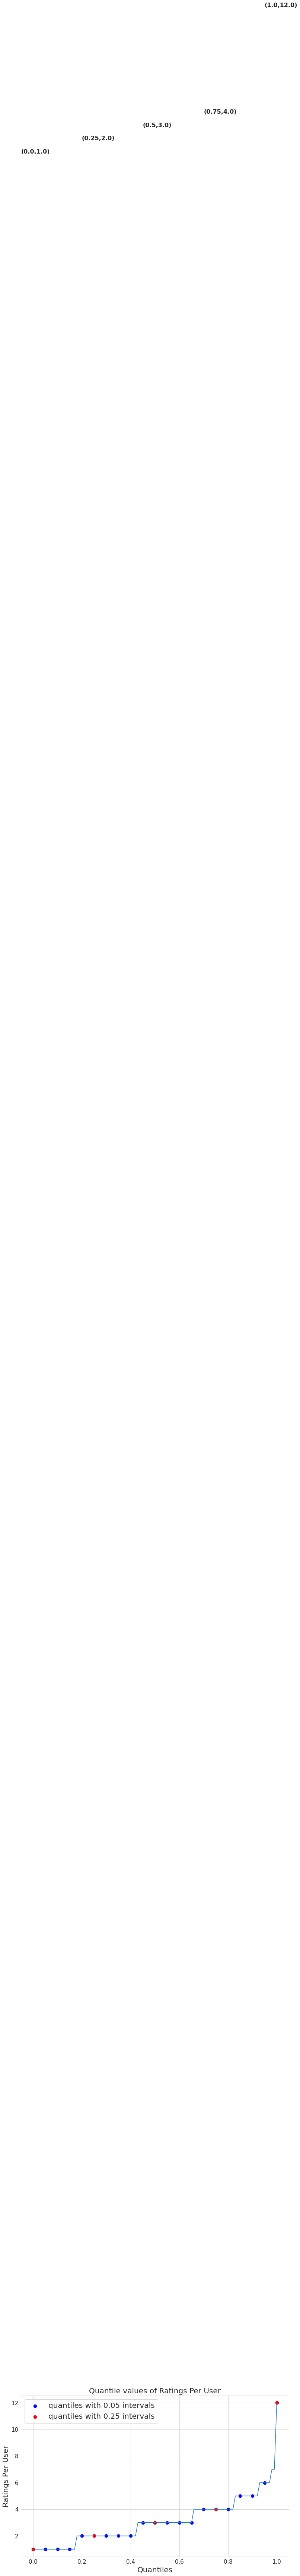

In [42]:
# fig = plt.figure(figsize = (10, 6))

# axes = fig.add_axes([0.1,0.1,1,1])
# axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
# axes.set_xlabel("Quantiles", fontsize = 20)
# axes.set_ylabel("Ratings Per User", fontsize = 20)
# axes.plot(quantiles)

# plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
# plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
# plt.legend(loc='upper left', fontsize = 20)

# for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
#     plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
# axes.tick_params(labelsize = 15)

In [43]:
quantiles[::5]

0.00     1.0
0.05     1.0
0.10     1.0
0.15     1.0
0.20     2.0
0.25     2.0
0.30     2.0
0.35     2.0
0.40     2.0
0.45     3.0
0.50     3.0
0.55     3.0
0.60     3.0
0.65     3.0
0.70     4.0
0.75     4.0
0.80     4.0
0.85     5.0
0.90     5.0
0.95     6.0
1.00    12.0
Name: Ratings, dtype: float64

In [44]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 52866
Total number of ratings above 75th percentile = 0


### Analysis of Ratings Per Movie

In [45]:
no_of_ratings_per_movie = Train_Data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

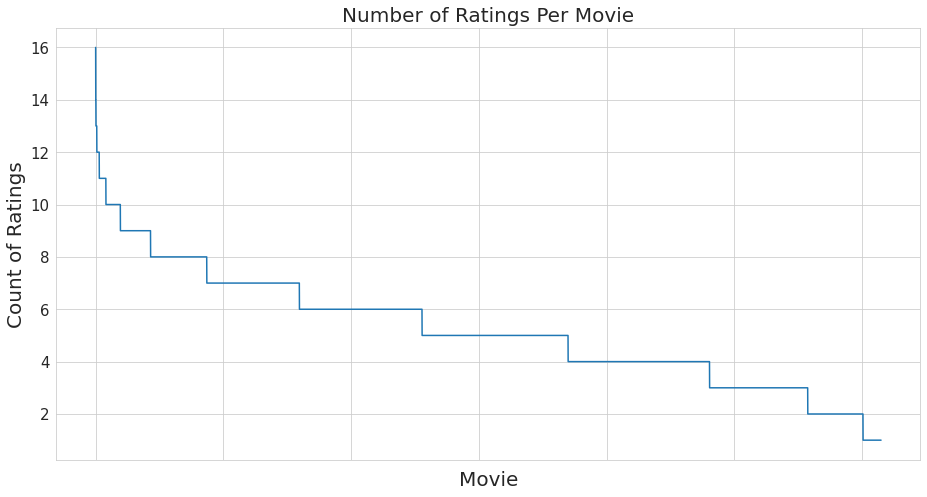

In [46]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

<b>It is very skewed</b>
<p>It clearly shows that there are some movies which are very popular and were rated by many users as comapared to other movies</p>

## 3. Creating USER-ITEM sparse matrix from data frame

In [47]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for train Data")
if os.path.isfile("/content/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("/content/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("/content/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data
We are creating sparse data
Creation done. Shape of sparse matrix = (56104, 61734)
Saving it into disk for furthur usage.
Done

0:00:00.179784


In [48]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for test Data")
if os.path.isfile("/content/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("/content/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("/content/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data
We are creating sparse data
Creation done. Shape of sparse matrix = (56102, 61734)
Saving it into disk for furthur usage.
Done

0:00:00.054742


In [49]:
#If you can see above that the shape of both train and test sparse matrices are same, furthermore, how come this shape of sparse
#matrix has arrived:
#Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
#Now the user whose user ID is highest is present in both train data and test data. Similarly, the movie whose movie ID is
#highest is present in both train data and test data. Hence, shape of both train and test sparse matrices are same.

In [50]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.99538074560826% 


In [51]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.99884509470533% 


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [52]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

### Global Average Rating

In [53]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 1.333391670677359


### Average Rating Per User

In [54]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)

In [55]:
# print("Average rating of user 25 = {}".format(AvgRatingUser[25]))

### Average Rating Per Movie

In [56]:
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)

In [57]:
# print("Average rating of movie 4500 = {}".format(AvgRatingMovie[4500]))

### Cold Start Problem

#### Cold Start Problem with Users

In [58]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 54483
Number of Users in train data= 52866
Number of Users not present in train data = 1617(3.0%)


#### Cold Start Problem with Movies

In [59]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 30839
Number of Movies in train data= 30744
Number of Movies not present in train data = 95(0.0%)


## 4. Machine Learning Models

In [60]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)   #this will give same random number everytime, without replacement
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - startTime)
    return sparse_sample

### Creating Sample Sparse Matrix for Train Data

In [61]:
path = "/content/TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (56064, 61676)
0:00:00.072261


### Creating Sample Sparse Matrix for Test Data

In [62]:
path = "/contentTestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (56097, 61556)
0:00:00.021393


### prepare error table

In [63]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [64]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

## 1. Alternating Least Squares

In [138]:
def evaluate_algo(model):
  precals = precision_at_k(model, TrainUISparseData, TestUISparseData, K=10, num_threads=4)
  mapals = mean_average_precision_at_k(model, TrainUISparseData, TestUISparseData, K=10, num_threads=4)
  aucals = AUC_at_k(model, TrainUISparseData, TestUISparseData, K=10, num_threads=4)
  ndcgals = ndcg_at_k(model, TrainUISparseData, TestUISparseData, K=10, num_threads=4)
  print(f"precision at k = {precals}")
  print(f"mean absolute precision at k = {mapals}")
  print(f"ndcg at k = {ndcgals}")
  print(f"auc at k = {aucals}")

In [110]:
train_sample_sparse.shape

(56064, 61676)

In [111]:
test_sample_sparse.shape

(56097, 61556)

In [112]:
test_sample_sparse

<56097x61556 sparse matrix of type '<class 'numpy.longlong'>'
	with 25 stored elements in Compressed Sparse Row format>

In [129]:
data_coo = sparse.csr_matrix(Final_Data.values.T)
train_sample_sparse, test_sample_sparse = train_test_split(data_coo)

In [133]:
TestUISparseData

<56102x61734 sparse matrix of type '<class 'numpy.longlong'>'
	with 39999 stored elements in Compressed Sparse Row format>

In [134]:
alsModel = ALS(factors=128,iterations=40, regularization=1.5, dtype=np.float64)
alsModel.fit(TrainUISparseData)

In [141]:
alsModel.recommend(1290, TrainUISparseData)

[(18685, 0.0),
 (18697, 0.0),
 (18709, 0.0),
 (18699, 0.0),
 (18700, 0.0),
 (18701, 0.0),
 (18702, 0.0),
 (18703, 0.0),
 (18704, 0.0),
 (18705, 0.0)]

In [140]:
evaluate_algo(alsModel)


precision at k = 0.0002500062501562539
mean absolute precision at k = 7.33702442313563e-05
ndcg at k = 0.00012569419229528788
auc at k = 0.5000499042427853


## 2. Bayesian Personalized Ranking

In [116]:
bprModel = BPR(factors=128,iterations=40, regularization=1.5, dtype=np.float64)
bprModel.fit(train_sample_sparse)

In [117]:
evaluate_algo(bprModel)


precision at k = 0.0
mean absolute precision at k = 0.0
ndcg at k = 0.0
auc at k = 0.4999187718300706


## 3. Logistic Matrix Factorization

In [118]:
lmfModel = LMF(factors=128,iterations=40, regularization=1.5, dtype=np.float64)
lmfModel.fit(test_sample_sparse)

100%|██████████| 40/40 [00:00<00:00, 802.34it/s]


In [119]:
evaluate_algo(lmfModel)


precision at k = 0.0
mean absolute precision at k = 0.0
ndcg at k = 0.0
auc at k = 0.4999187718300707


## 4. SVD++

### Utility Functions for Surprise Models

In [75]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [76]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted
#in surprise prediction of every data point is returned as dictionary like this:
#"user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating 

In [77]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [78]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    #You can check out above function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    #You can check out "trainset.build_testset()" function at "https://surprise.readthedocs.io/en/stable/FAQ.html#can-i-use-my-own-dataset-with-surprise-and-can-it-be-a-pandas-dataframe" in 
    #"How to get accuracy measures on the training set" section
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

#### Cross- Validation

In [79]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(Train_Data, reader)

In [80]:
# #skip this for now :)
# param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

# gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

# gs.fit(data)

# # best RMSE score
# print(gs.best_score['rmse'])

# # combination of parameters that gave the best RMSE score
# print(gs.best_params['rmse'])

#### Applying SVDpp with best parameters

In [81]:
trainset = list(zip(Train_Data["CustID"].values, Train_Data["MovieID"].values, Train_Data["Ratings"].values))
trainset = data.build_full_trainset()

In [82]:
testset = list(zip(Test_Data["CustID"].values, Test_Data["MovieID"].values, Test_Data["Ratings"].values))

In [83]:
testset[9:15]

[(9484, 36489, 1),
 (47217, 26291, 3),
 (44041, 16093, 1),
 (8242, 5895, 1),
 (54650, 57431, 1),
 (6098, 47233, 1)]

In [84]:
# algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)
algo = SVDpp(n_factors = 20, lr_all = 0.05, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 1.486104825768427
MAPE = 9.389296754405448
--------------------------------------------------
TEST DATA
RMSE = 1.3809055000252553
MAPE = 9.51133809168629
--------------------------------------------------
Time Taken = 0:00:25.596235


#### evaluate SVD++ with AUC

In [85]:
prec_to_ave = []
rec_to_ave = []
kf = KFold(n_splits=5)
predictions = algo.test(testset)

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    
    prec_to_ave.append(sum(prec for prec in precisions.values()) / len(precisions))
    rec_to_ave.append(sum(rec for rec in recalls.values()) / len(recalls))

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8


In [86]:
def make_binary_tpr_fpr(predictions, threshold=3.5):
    pred_df = pd.DataFrame(predictions)
    pred_df['r_ui'].where(pred_df['r_ui']>threshold, 1, inplace=True)
    pred_df['r_ui'].where(pred_df['r_ui']<=threshold, 0, inplace=True)
    
    pred_df['est'].where(pred_df['est']>threshold, 1, inplace=True)
    pred_df['est'].where(pred_df['est']<=threshold, 0, inplace=True)

    return pred_df['r_ui'], pred_df['est'], 

true_r, est = make_binary_tpr_fpr(predictions)

In [87]:
fpr, tpr, thresholds = roc_curve(true_r, est)
svdauc = auc(fpr, tpr)

In [88]:
def graph_roc (true_r, est):
    plt.plot(fpr,tpr, '-')
    plt.ylabel("FPR/Precision Scores")
    plt.xlabel("TPR/Recall Scores")
    plt.title("ROC Scores and Auc of " + str(svdauc))
    plt.show()

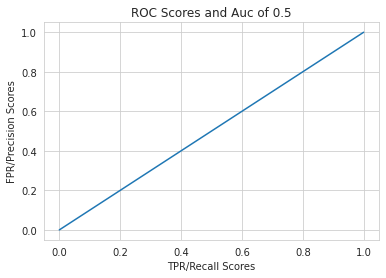

In [89]:
graph_roc(true_r, est)

In [90]:
svdauc

0.5

## Summary

In [91]:
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

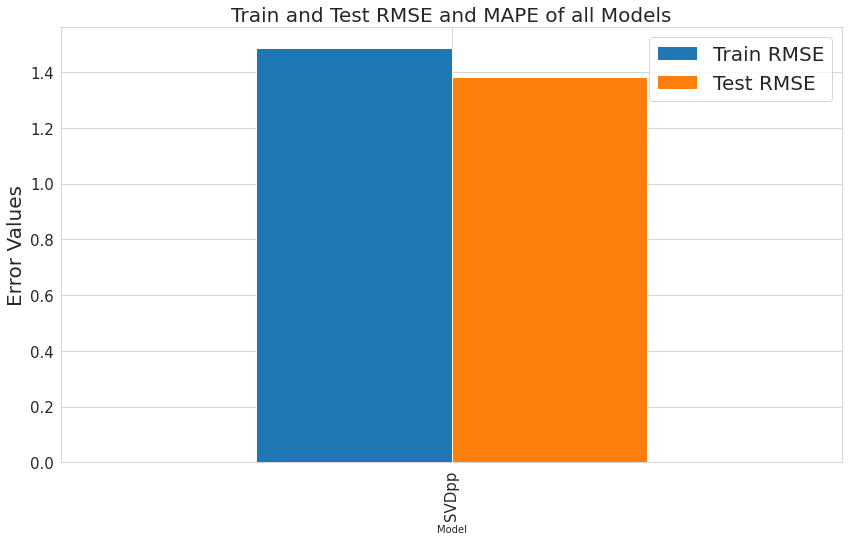

In [92]:
error_table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [93]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1).style.highlight_min(axis=0)

,Model,Train RMSE,Test RMSE
0,SVDpp,1.486105,1.380906


# So, far our best model is SVDpp with Test RMSE of 1.067583